In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import make_pipeline
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sksurv.nonparametric import kaplan_meier_estimator
from sksurv.preprocessing import OneHotEncoder
from sksurv.ensemble import RandomSurvivalForest
from sksurv.ensemble import ComponentwiseGradientBoostingSurvivalAnalysis
from sksurv.ensemble import GradientBoostingSurvivalAnalysis
from sksurv.metrics import concordance_index_censored
from google.oauth2 import service_account
from sksurv.metrics import as_cumulative_dynamic_auc_scorer
from sklearn.model_selection import cross_val_score
from sksurv.metrics import cumulative_dynamic_auc
from sklearn.model_selection import KFold
import pickle
import pandas_gbq as gbq


In [54]:
# # Set your credentials path
# credentials_path = 'token.json'

# # Authenticate with your credentials
# credentials = service_account.Credentials.from_service_account_file(
#     credentials_path, scopes=['https://www.googleapis.com/auth/bigquery'])

# # Set the credentials for pandas_gbq
# gbq.context.credentials = credentials

# project_id = 'capstone-402105'
# dataset_id = 'capstone'
# table_id = "CRI-Compustat-Merged-2"

# from pandas_gbq import read_gbq

# # Specify the chunk size (e.g., 1000 rows per chunk)
# chunk_size = 1000
# offset = 0

# # Initialize an empty DataFrame to hold the combined data
# df_combined = pd.DataFrame()

# while True:
#     # Build your SQL query with LIMIT and OFFSET
#     query = f"""
#     SELECT *
#     FROM `{project_id}.{dataset_id}.{table_id}`
#     LIMIT {chunk_size}
#     OFFSET {offset}
#     """
    
#     # Authenticate and read data from BigQuery into a DataFrame for the current chunk
#     df_chunk = read_gbq(query, project_id=project_id, dialect='standard')
    
#     # Check if the chunk has any data, and break the loop if not
#     if df_chunk.empty:
#         break

#     # Append the chunk to the combined DataFrame
#     df_combined = pd.concat([df_combined, df_chunk], ignore_index=True)

#     # Increment the offset to fetch the next chunk
#     offset += chunk_size

# df_combined.head()

# Specify the path to your pickle file
file_path = "../dataset/merged_data.pkl"

# Open the pickle file for reading
with open(file_path, 'rb') as file:
    # Load the data from the pickle file
    df = pickle.load(file)

df.head()



,CompanyNumber,yyyy,mm,DTDmedianFin,DTDmedianNonFin,dummy297fin,EventDate,EventDate_string,Duration,StartDate,...,equity_ratio,financial_leverage_ratio,cashflow_to_debt_ratio,net_profit_margin,asset_turnover,receivables_turnover,day_sales_outstanding,working_capital_turnover,price_to_earnings,retention_ratio
0,26980,2000.0,5,0.0,2.190874,0.0,2000-05-01 00:00:00+00:00,2000 05,4501 days 00:00:00,1988-01-04 00:00:00+00:00,...,8.653470,0.115561,0.353320,0.496181,0.500283,0.439043,2.277680,6.329094,-10.552301,5.626957
1,26995,2000.0,12,0.0,1.863172,0.0,2000-12-01 00:00:00+00:00,2000 12,4715 days 00:00:00,1988-01-04 00:00:00+00:00,...,5.227711,0.191288,0.270503,0.309987,0.252043,5.105960,0.195850,-30.840000,98.727273,0.127184
2,27003,2000.0,6,0.0,2.257787,0.0,2000-06-01 00:00:00+00:00,2000 06,4532 days 00:00:00,1988-01-04 00:00:00+00:00,...,2.758440,0.362524,0.040856,0.553460,0.471932,0.027663,42.234378,1.449149,42.256637,13.899441
3,27058,2000.0,3,0.0,2.599548,0.0,2000-03-01 00:00:00+00:00,2000 03,4440 days 00:00:00,1988-01-04 00:00:00+00:00,...,0.977792,1.022712,0.154983,0.351704,1.000000,2.866751,0.348827,0.677361,14.625000,5.160377
4,27071,2000.0,4,0.0,2.318686,0.0,2000-04-01 00:00:00+00:00,2000 04,4471 days 00:00:00,1988-01-04 00:00:00+00:00,...,0.883145,1.132316,0.307483,0.303481,0.541856,1.503662,0.665043,3.567568,17.829861,14.014418


In [55]:
# df['transformed_status'] = df['EventType'].map(lambda x : 1 if x == 1 else 0)
# df['transformed_status'] = df['EventType']

# Data preprocessing
# df['transformed_year'] = df['yyyy'].apply(lambda x: x - 2000)
df['transformed_status'] = df['EventType'].map(lambda x : True if x == 0.0 else False)
df['Duration'] = df['Duration'].str.extract(r'(\d+) days').astype(int)


features_to_drop = ['yyyy','mm','EventDate', 'EventDate_string', 'StartDate', 'EventType', 'datadate', 'Duration', 'transformed_status', 'atq', 'ltq', 'dlcq', 'txditcq', 'cheq', 'lctq', 'actq', 'invtq', 'intanq',
'oibdpq', 'txpq', 'piq', 'niq', 'revtq', 'cogsq', 'oancfy', 'ivncfy', 'fincfy', 'dltisy', 'dltry', 'ceqq', 'dpq', 'saleq', 'saley', 'invchy','rectq', 'wcapq', 'prccq', 'epsf12', 'cshoq', 'dvy', 'req', 'dlttq', 'chechy']
X = df.drop(features_to_drop, axis=1)  # Features

# X = df.drop(['EventDate_notNA','EventType', 'Sector_Number_notNA', 'Exchange_notNA'], axis=1)  # Features
# time_column = df['transformed_year'].values
time_column = df['Duration']
event_column = df['transformed_status'].values
y = np.array(list(zip(event_column,time_column)), dtype=[('transformed_status', bool), ('duration', int)])

c:\Users\Melissa\AppData\Local\Programs\Python\Python310\lib\site-packages\sksurv\nonparametric.py:200: RuntimeWarning: invalid value encountered in sqrt
  sigma = np.sqrt(np.cumsum(ratio_var))


Text(0.5, 0, 'time $t$')

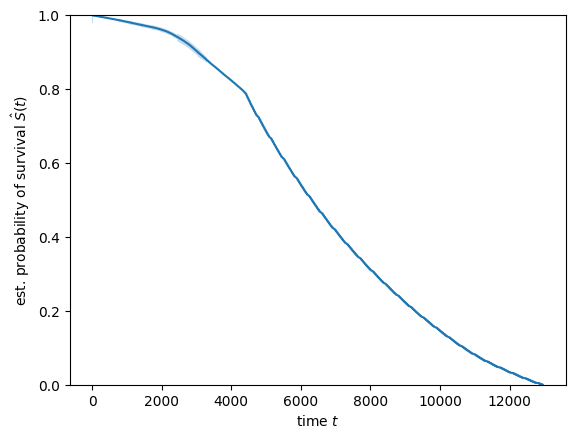

In [56]:
time, survival_prob, conf_int = kaplan_meier_estimator(
    y["transformed_status"], y["duration"], conf_type="log-log"
)
plt.step(time, survival_prob, where="post")
plt.fill_between(time, conf_int[0], conf_int[1], alpha=0.25, step="post")
plt.ylim(0, 1)
plt.ylabel("est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")

In [57]:
# Data preprocessing
# X = df.drop(['yyyy', 'EventDate_notNA','Event_type', 'Sector_Number_notNA', 'Exchange_notNA', 'transformed_status','transformed_year', 'status_boolean'], axis=1)  # Features
#df_new = df.copy()
# df_new.dropna(inplace=True)

#X = df_new.drop(['EventDate','EventType','transformed_year', 'status_boolean', 'yyyy', 'mm'], axis=1)  # Features
#y = np.array(list(zip(df_new['status_boolean'], df_new['transformed_year'])), dtype=[('event', bool), ('time', int)])

# encoder = OneHotEncoder()
# X_encoded = encoder.fit_transform(X)

# Imputing Nan
# X_encoded = X_encoded.fillna(0)

# Scaling
# scaler = StandardScaler()
# X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [58]:
X_train.head()

,CompanyNumber,DTDmedianFin,DTDmedianNonFin,dummy297fin,gvkey,sic,sector_industry,current_ratio,quick_ratio,cash_ratio,...,equity_ratio,financial_leverage_ratio,cashflow_to_debt_ratio,net_profit_margin,asset_turnover,receivables_turnover,day_sales_outstanding,working_capital_turnover,price_to_earnings,retention_ratio
548910,29101,2.1486,0.000000,1.0,25075,6035.0,60,2.447407,2.357784,-0.000245,...,1.545897,0.646874,0.089763,0.603550,0.503380,0.715552,1.233268,3.107530,30.769231,8.847978
539059,29889,0.0000,4.673793,0.0,7185,3567.0,35,3.267625,0.990880,-0.010523,...,1.000215,0.999785,0.019199,0.339871,1.000000,1.603920,0.623473,0.481052,37.750000,53.394495
129092,30469,0.0000,4.729370,0.0,12597,3842.0,38,2.517910,1.306934,0.895132,...,0.351361,2.846078,0.969854,0.499852,0.503582,15.551718,0.064302,0.726007,14.489362,3.012042
535310,28223,0.0000,3.868866,0.0,10618,3523.0,35,2.568082,2.424620,-0.001312,...,1.594747,0.627059,0.114562,0.504109,0.488787,0.643488,1.425451,1.500752,43.333333,14.310707
62971,31862,0.0000,4.647925,0.0,10200,3674.0,36,3.901586,2.802446,-0.579620,...,1.222206,0.818193,-1.892015,0.431055,0.440479,1.519710,0.658020,0.559824,-6.316667,-33.430685


In [59]:
# Survival model - Cox Proportional Hazards (CoxPH) model
estimator = CoxPHSurvivalAnalysis()
estimator.fit(X_train, y_train)


CoxPHSurvivalAnalysis()

In [60]:
prediction = estimator.predict(X_test)

c_index = estimator.score(X_test, y_test)
print(f"Concordance Index (C-index): {c_index:.4f}")

c:\Users\Melissa\AppData\Local\Programs\Python\Python310\lib\site-packages\sksurv\metrics.py:139: RuntimeWarning: overflow encountered in long_scalars
  concordant += n_con
c:\Users\Melissa\AppData\Local\Programs\Python\Python310\lib\site-packages\sksurv\metrics.py:140: RuntimeWarning: overflow encountered in long_scalars
  discordant += est.size - n_con - n_ties


Concordance Index (C-index): 0.6528


In [45]:
pd.Series(estimator.coef_, index=X.columns)

CompanyNumber               2.542239e-06
DTDmedianFin               -3.203027e-01
DTDmedianNonFin            -1.391747e-01
dummy297fin                 4.445770e-01
gvkey                       3.164195e-05
sic                        -5.279319e-05
atq                         3.253414e-06
ltq                        -2.702094e-06
dlcq                       -2.568966e-06
txditcq                    -1.125185e-06
cheq                       -5.162833e-07
lctq                        1.246589e-04
actq                       -1.222131e-04
invtq                      -4.436388e-06
intanq                     -3.169088e-06
oibdpq                      7.747444e-06
txpq                       -1.843363e-05
piq                         5.897495e-06
niq                        -9.504838e-06
revtq                      -2.235723e-06
cogsq                       5.105836e-06
oancfy                      4.026798e-06
ivncfy                      2.098233e-06
fincfy                     -6.955815e-06
dltisy          

In [61]:
# # Create and fit the GradientBoostingSurvivalAnalysis model
# gbsa = GradientBoostingSurvivalAnalysis()
# gbsa.fit(X_train, y_train)

# # Predict survival probabilities
# predicted_survival = gbsa.predict(X_test)

# # Evaluate the model using concordance index
# c_index = concordance_index_censored(y_test, predicted_survival)
# print("Concordance Index:", c_index)

In [34]:
# Create a Cox PH model
cph = CoxPHSurvivalAnalysis()

# Split your data into training and test sets (or use a different cross-validation strategy)
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Lists to store results
cumulative_auc_values = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Fit the model on the training data
    cph.fit(X_train, y_train)

    # Predict survival probabilities for the test data
    predicted_survival = cph.predict(X_test)

    # Calculate the cumulative/dynamic AUC-ROC
    cumulative_auc = cumulative_dynamic_auc(y_train, y_test, predicted_survival, times=[1, 3, 5])
    cumulative_auc_values.append(cumulative_auc)

# Now, cumulative_auc_values contains the cumulative AUC-ROC values for each fold of cross-validation


KeyError: "None of [Int64Index([     1,      3,      4,      5,      8,      9,     10,     11,\n                13,     14,\n            ...\n            579213, 579214, 579215, 579217, 579218, 579219, 579220, 579221,\n            579222, 579223],\n           dtype='int64', length=463380)] are in the [columns]"

Random Survival Forest


In [11]:
rsf = RandomSurvivalForest(
    n_estimators=1000, min_samples_split=10, min_samples_leaf=15, n_jobs=-1, random_state=20
)
rsf.fit(X_train, y_train)

In [ ]:
rsf.score(X_test, y_test)